In [33]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [43]:
actions = ['one', 'standby', 'input']

data = np.concatenate([
    np.load('dataset/seq_one_1652965337.npy'),
    np.load('dataset/seq_standby_1652965337.npy'),
    np.load('dataset/seq_input_1652965337.npy')
], axis=0)

data.shape

(816, 30, 100)

In [44]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(816, 30, 99)
(816,)


In [45]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(816, 3)

In [46]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.15, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(693, 30, 99) (693, 3)
(123, 30, 99) (123, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalizatio

In [47]:
## gesture 학습 모델
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                41984     
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/100
21/22 [===========================>..] - ETA: 0s - loss: 4.2241 - acc: 0.5372
Epoch 1: val_acc improved from -inf to 0.79675, saving model to models\model.h5
22/22 [==============================] - 2s 30ms/step - loss: 4.1337 - acc: 0.5440 - val_loss: 1.3399 - val_acc: 0.7967 - lr: 0.0010
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 1.2228 - acc: 0.8348
Epoch 2: val_acc improved from 0.79675 to 0.83740, saving model to models\model.h5
22/22 [==============================] - 0s 18ms/step - loss: 1.2790 - acc: 0.8326 - val_loss: 1.9507 - val_acc: 0.8374 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 2.2037 - acc: 0.8182
Epoch 3: val_acc did not improve from 0.83740
22/22 [==============================] - 0s 16ms/step - loss: 2.2037 - acc: 0.8182 - val_loss: 2.8792 - val_acc: 0.8211 - lr: 0.0010
Epoch 4/100
20/22 [==========================>...] - ETA: 0s - loss: 1.1439 - acc: 0.8219
Epoch 4: val_acc did not improve

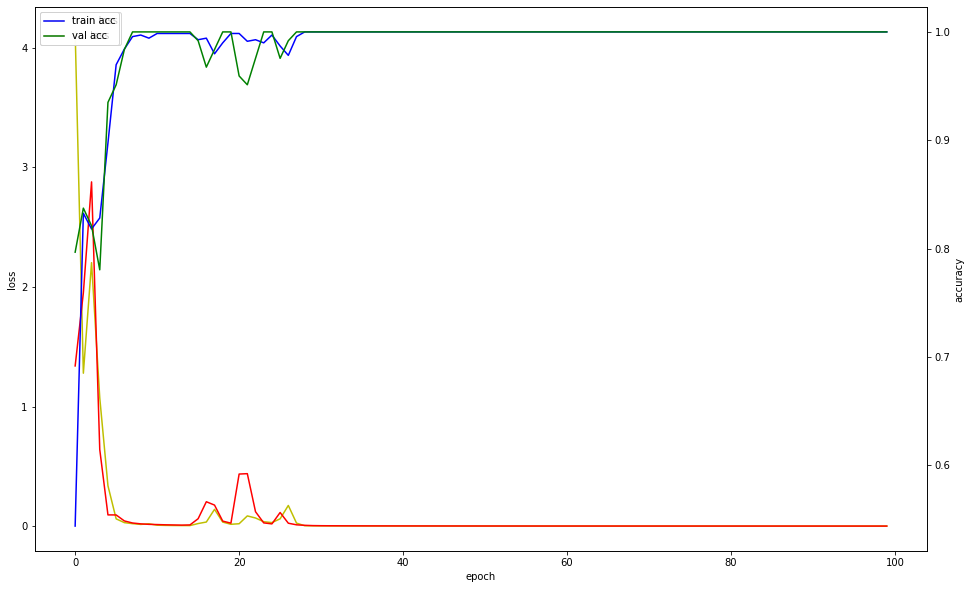

In [49]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [50]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[76,  0],
        [ 0, 47]],

       [[78,  0],
        [ 0, 45]],

       [[92,  0],
        [ 0, 31]]], dtype=int64)